In [1]:
import flickrapi
import time
import xml.etree.ElementTree as ET
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import preprocessing
import seaborn as sns
import folium
from folium.plugins import HeatMap

# your API key and secret
api_key = u'3a500e823f55613be4f5acee369d4041'
api_secret = u'b7ac06684cafe24f'

# creation of a FlickrAPI object
flickr = flickrapi.FlickrAPI(api_key, api_secret)

In [2]:
# create a default dictionary to store information about the photos 
# the keys are the attributes of interest and the values the data
photo_information = defaultdict(list)

# we loop through the different pages that contain photos of London taken in 2019
i = 1
while True:     
    result = flickr.photos.search(
                    per_page=400, #number of data per page
                    has_geo=1, #Photo that has geo location
                    min_taken_date='2019-1-01', # minimum date - 1 Jan 2019
                    max_taken_date='2019-12-31', # maximum data - 31 Dec 2019
                    bbox='-0.5103,51.2868,0.3340,51.6919', # boundary box of London
                    media='photos', #collecting only photos (videos excluded)
                    sort='date-taken-desc', 
                    privacy_filter=1,#collecting only public photos (private photos excluded)
                    safe_search=1, #photos without violence
                    extras='geo,url_n,date_taken,views,license',
                    page=i)
    
    # pause the execution of the program 2 seconds
    time.sleep(2)
    
    # obtain the number of pages (first iteration)
    # this information is contained in the photos tag and it will allows us to determine when to break the loop
    if i == 1:
        pages = int(result[0].attrib['pages'])
        print('Number of pages: {}'.format(pages))
    
    # print the number of the page - iteration of the while loop
    print(i, end=' ')  
    
    # loop through all the photos available in the page
    # store (1) the id, (2) the latitude, (3) the longitude, and (4) the URL of the photo in the dictionary  
    for element in result[0].findall('photo'):
        photo_information['id'].append(element.attrib['id'])
        photo_information['latitude'].append(element.attrib['latitude'])
        photo_information['longitude'].append(element.attrib['longitude'])
        photo_information['url_n'].append(element.attrib['url_n'])

    # if the page correspond to the last page we break the loop  
    if i == pages:
        break
    else:
        i = i + 1

Number of pages: 18
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

In [3]:
# visualize the tree structure of the XML element obtained after calling the search function
ET.dump(result[0][0])

<photo id="49304563418" owner="48524258@N00" secret="a7be17588c" server="65535" farm="66" title="IMG_20191231_125014349" ispublic="1" isfriend="0" isfamily="0" license="5" datetaken="2019-12-31 12:50:14" datetakengranularity="0" datetakenunknown="0" views="10" latitude="51.383127" longitude="-0.107378" accuracy="16" context="0" place_id="" woeid="2651817" geo_is_public="1" geo_is_contact="0" geo_is_friend="0" geo_is_family="0" url_n="https://live.staticflickr.com/65535/49304563418_a7be17588c_n.jpg" height_n="240" width_n="320" />
	


In [4]:
# convert the dictionary into a Pandas dataframe
df_photos = pd.DataFrame(photo_information) 

# visualize the first 5 rows of the dataframe
df_photos.head()

,id,latitude,longitude,url_n
0,49304563418,51.383127,-0.107378,https://live.staticflickr.com/65535/4930456341...
1,49305754441,51.505109,0.063257,https://live.staticflickr.com/65535/4930575444...
2,49305195797,51.530746,-0.137929,https://live.staticflickr.com/65535/4930519579...
3,49849395713,51.512956,-0.083524,https://live.staticflickr.com/65535/4984939571...
4,49358371881,51.511266,-0.139067,https://live.staticflickr.com/65535/4935837188...


In [5]:
# get a summary of the data frame
df_photos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4498 entries, 0 to 4497
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         4498 non-null   object
 1   latitude   4498 non-null   object
 2   longitude  4498 non-null   object
 3   url_n      4498 non-null   object
dtypes: object(4)
memory usage: 140.7+ KB


In [6]:
# convert the columns latitude and longitud into floats
df_photos['latitude'] = df_photos['latitude'].astype(float)
df_photos['longitude'] = df_photos['longitude'].astype(float)

In [7]:
# number of duplicated photos in the data set
df_photos.duplicated().sum()

np.int64(250)

In [8]:
# eliminate duplicated photos from the data set
df_photos = df_photos.drop_duplicates()

# size of the data set after removing duplicated photos
df_photos.shape

(4248, 4)

In [9]:
# remove id and url_n columns from the data set
df_photos.drop(['id', 'url_n'], axis=1, inplace=True)

In [10]:
# save the data set as a csv file
df_photos.to_csv('london_photos.csv')

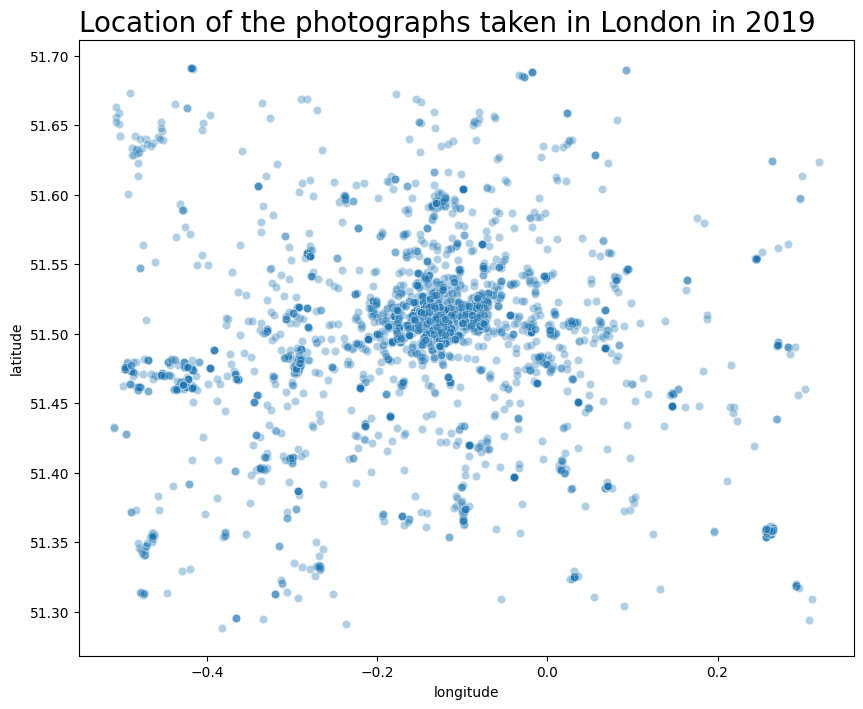

In [11]:
# visualization of the results with a scatter plot
fig = plt.figure(figsize=(10, 8))
plt.title('Location of the photographs taken in London in 2019', loc='left', fontsize=20)
sns.scatterplot(x=df_photos.longitude, y=df_photos.latitude, alpha=.35);

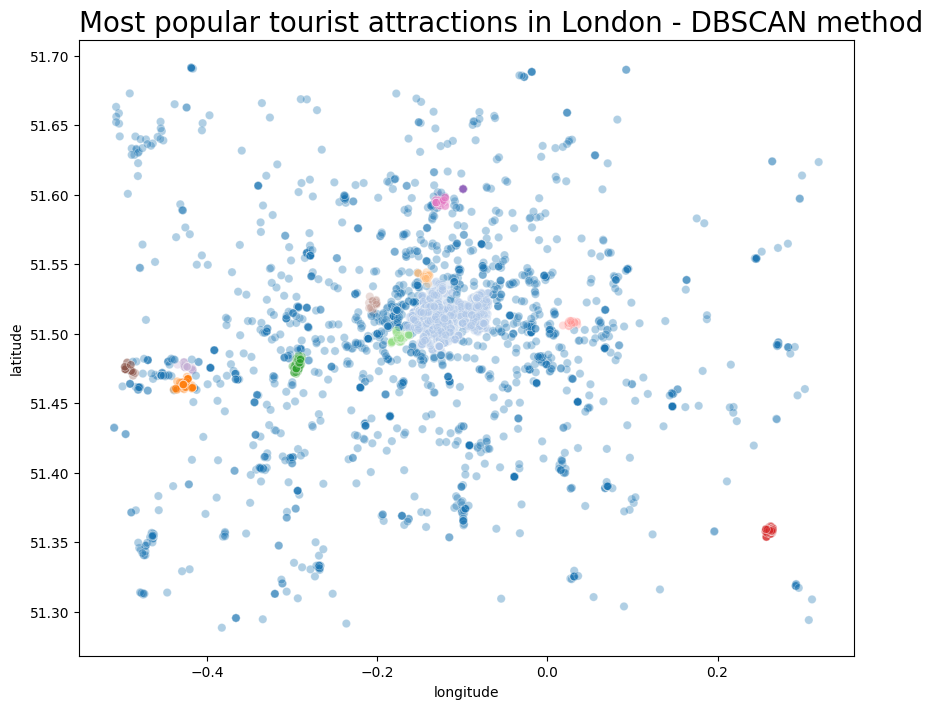

In [12]:
# normalization of the data using the min max method
scaler = preprocessing.MinMaxScaler()

# normalization - fit and transform the data
df_photos_scaled = scaler.fit_transform(df_photos)

# apply the dbscan algorithm to the dataset
tourist_points = cluster.DBSCAN(eps=0.010, min_samples=35).fit(df_photos_scaled)

# labels of the clusters
labels_tourist_points = tourist_points.labels_

# visualization of the results with a scatter plot
fig = plt.figure(figsize=(10, 8))
plt.title('Most popular tourist attractions in London - DBSCAN method', loc='left', fontsize=20)
sns.scatterplot(x=df_photos.longitude, y=df_photos.latitude, alpha=.35,
                hue=labels_tourist_points, palette="tab20", legend=None);